Tutorial 1: Fit Problems
========================

To begin, make sure you have read the `introduction` file carefully, as a clear understanding of how the Bayesian
log_evidence works is key to understanding this chapter!

In the previous chapter we investigated two `Pixelization``.; Rectangular and VoronoiMagnification. We learnt that the
latter was better than the former, because it dedicated more source-pixels to the regions of the source-plane where we
had more data, e.g, the high-magnification regions. Therefore, we could fit the data using fewer source pixels,
which improved computational efficiency and the Bayesian log evidence.

So far, we've used just one `Regularization` scheme; Constant. As the name suggests, this `Regularization` scheme applies
just one regularization_coefficient when regularizing source-pixels with one another. In case you`ve forgot, here is
a refresher of `Regularization`, from chapter 4:

-------------------------------------------- 

When our `Inversion` reconstructs a source, it doesn`t *just* compute the set of fluxes that best-fit the image. It
also `regularizes` this solution, going to every pixel on our rectangular `Grid2D` and comparing its reconstructed flux
with its 4 neighboring pixels. If the difference in flux is large the solution is penalized, reducing its log likelihood.
You can think of this as us applying a prior that our source galaxy solution is `smooth`.

This adds a `penalty term` to the log likelihood of an `Inversion` which is the summed difference between the reconstructed
fluxes of every source-pixel pair multiplied by the regularization_coefficient. By setting the regularization
coefficient to zero, we set this penalty term to zero, meaning that `Regularization`.s omitted.

Why do we need to regularize our solution? Well, we just saw why - if we don't apply this smoothing, we `over-fit`
the image. More specifically, we over-fit the noise in the image, which is what the large flux values located at the
exteriors of the source reconstruction are doing. Think about it, if your sole aim is to maximize the log likelihood, the
best way to do this is to fit *everything* accurately, including the noise.

----------------------------------------------

So, when using a Constant `Regularization` scheme, we regularize the source by adding up the difference in fluxes
between all source-pixels multiplied by one single value of a regularization_coefficient. This means that every
single source pixel receives the same `level` of `Regularization`, regardless of whether it is reconstructing the
bright central regions of the source or its faint exterior regions.


In this tutorial, we'll learn that our magnification-based `Pixelization` and constant `Regularization`.chemes are far
from optimal. To understand why, we'll inspect fits to three strong lenses, simulated using the same `MassProfile` but
with different sources whose `LightProfile`'s become gradually more compact. For all 3 fits, we'll use the same
source-plane resolution and a regularization_coefficient that maximize the Bayesian log evidence. Thus, these are the
`best` source reconstructions we can hope to achieve when adapting to the magnification.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use 3 sources whose effective radius and Sersic index are changed such that each is more compact that the last.

In [2]:
source_galaxy_flat = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.15),
        intensity=0.2,
        effective_radius=0.5,
        sersic_index=1.0,
    ),
)

source_galaxy_compact = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.15),
        intensity=0.2,
        effective_radius=0.2,
        sersic_index=2.5,
    ),
)

source_galaxy_super_compact = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.0, 0.0),
        elliptical_comps=(0.0, 0.15),
        intensity=0.2,
        effective_radius=0.1,
        sersic_index=4.0,
    ),
)

The function below uses each source galaxy to simulate `Imaging` data. It performs the usual tasks we are used to 
seeing (make the PSF, `Galaxy`'s , `Tracer`, etc.).

In [3]:


def simulate_for_source_galaxy(source_galaxy):

    grid = al.Grid2D.uniform(shape_native=(150, 150), pixel_scales=0.05, sub_size=2)

    psf = al.Kernel2D.from_gaussian(
        shape_native=(11, 11), sigma=0.05, pixel_scales=0.05
    )

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
        ),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    simulator = al.SimulatorImaging(
        exposure_time=300.0,
        psf=psf,
        background_sky_level=100.0,
        add_poisson_noise=True,
        noise_seed=1,
    )

    return simulator.from_tracer_and_grid(tracer=tracer, grid=grid)


we'll use the same 3.0" mask to fit all three of our sources.

In [4]:
mask = al.Mask2D.circular(
    shape_native=(150, 150), pixel_scales=0.05, sub_size=2, radius=3.0
)

Now, lets simulate all 3 of our source's as `Imaging` data.

In [5]:
imaging_source_flat = simulate_for_source_galaxy(source_galaxy=source_galaxy_flat)

imaging_source_compact = simulate_for_source_galaxy(source_galaxy=source_galaxy_compact)

imaging_source_super_compact = simulate_for_source_galaxy(
    source_galaxy=source_galaxy_super_compact
)

we'll make one more useful function which fits each simulated `Imaging` with a VoronoiMagniication `Pixelization` and 
_Constant_ `Regularization` scheme.

we'll input the regularization_coefficient of each fit, so that for each simulated source we regularize it at an 
appropriate level. Again, there is nothing new in this function you haven't seen before.

In [6]:


def fit_imaging_with_voronoi_magnification_pixelization(
    imaging, mask, regularization_coefficient
):

    masked_imaging = al.MaskedImaging(
        imaging=imaging,
        mask=mask,
        settings=al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2),
    )

    lens_galaxy = al.Galaxy(
        redshift=0.5,
        mass=al.mp.EllipticalIsothermal(
            centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
        ),
    )

    source_galaxy = al.Galaxy(
        redshift=1.0,
        pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
        regularization=al.reg.Constant(coefficient=regularization_coefficient),
    )

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


Lets fit our first source with the flattest `LightProfile`. One should note that this uses the highest `Regularization`
coefficient of our 3 fits (as determined by maximizing the Bayesian log evidence).

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


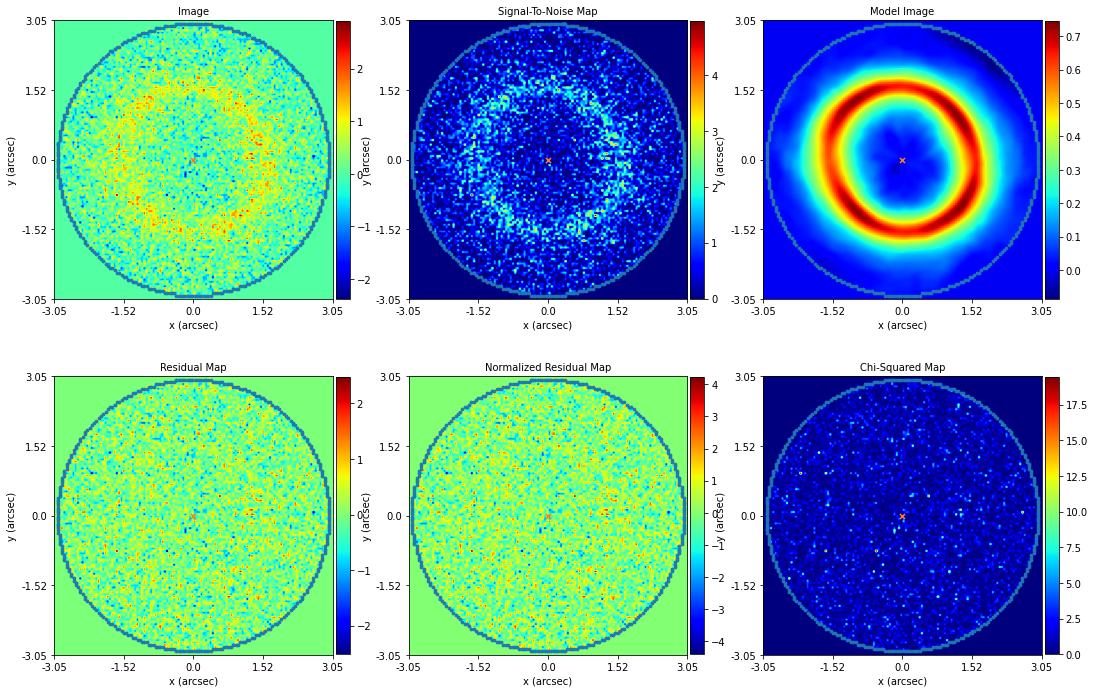

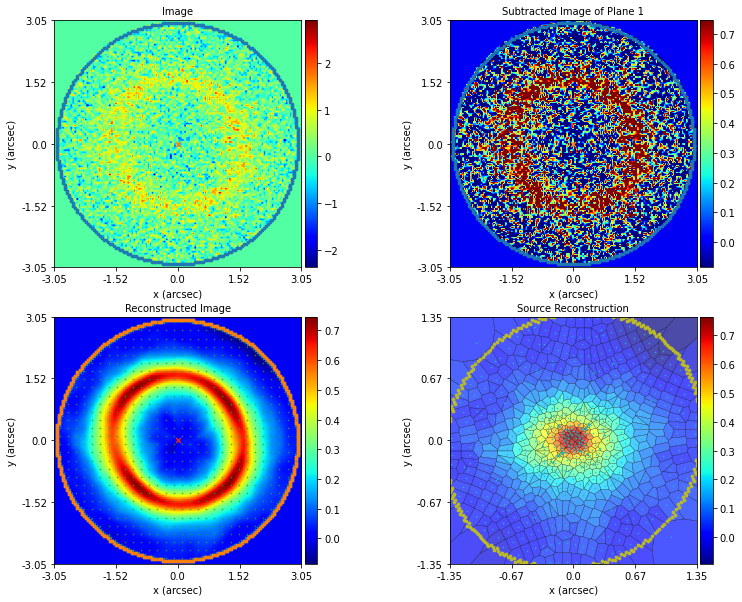

-10025.082687160299


In [7]:
fit_flat = fit_imaging_with_voronoi_magnification_pixelization(
    imaging=imaging_source_flat, mask=mask, regularization_coefficient=9.2
)

include_2d = aplt.Include2D(mapper_data_pixelization_grid=True, mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit_flat, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)


print(fit_flat.log_evidence)

Okay, so the fit was *excellent*. There were effectively no residuals in the fit, and the source has been 
reconstructed using lots of pixels! Nice!

Now, lets fit the next source, which is more compact.

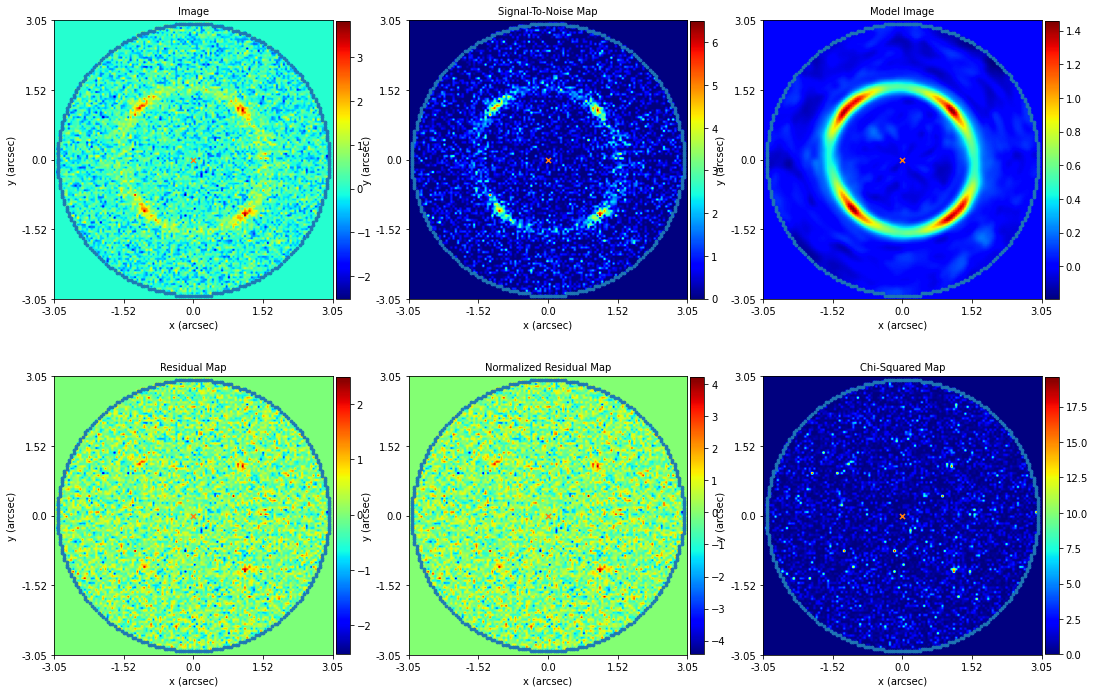

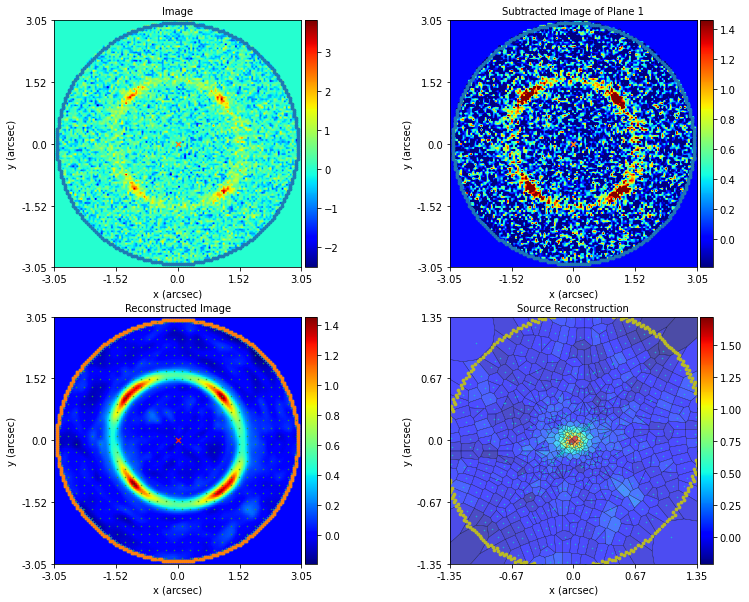

-10090.148740695402


In [8]:
fit_compact = fit_imaging_with_voronoi_magnification_pixelization(
    imaging=imaging_source_compact, mask=mask, regularization_coefficient=3.3
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit_compact, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

print(fit_compact.log_evidence)

Oh no! The fit doesn`t look so good! Sure, we reconstruct *most* of the lensed source's structure, but there are two 
clear `blobs` in the residual-map where we are failing to reconstruct the central regions of the source galaxy.

Take a second to think about why this might be. Is it the `Pixelization`. The `Regularization`.

Okay, so finally, we're going to fit our super compact source. Given that the results for the compact source didn`t 
look so good, you`d be right in assuming this is just going to make things even worse. Again, think about why this 
might be.

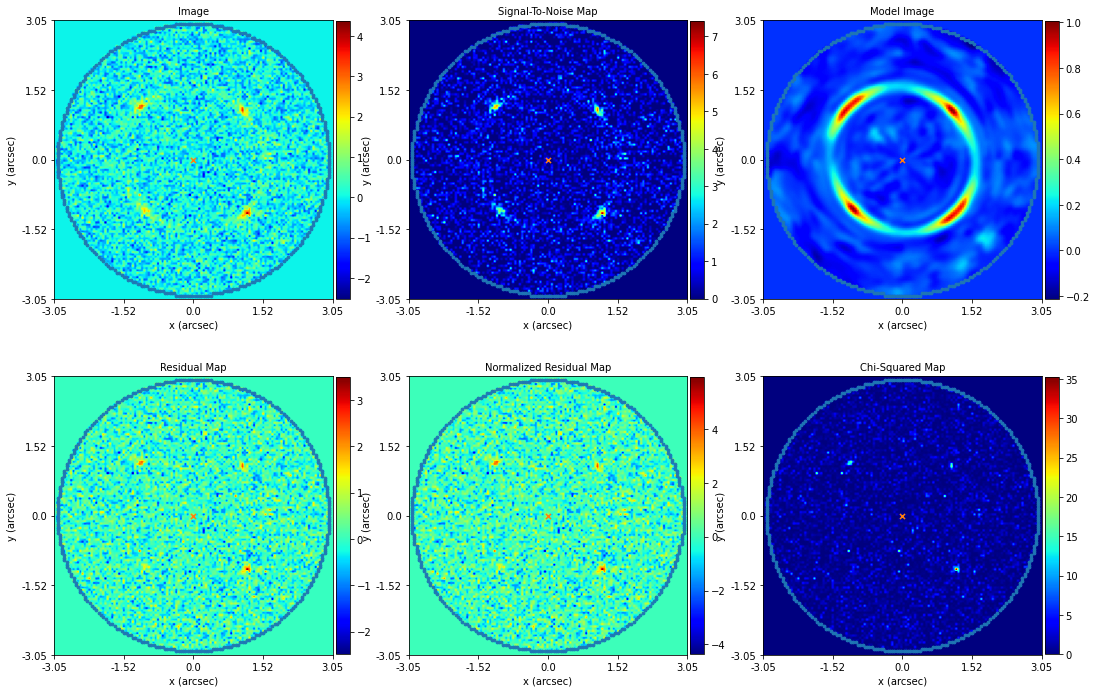

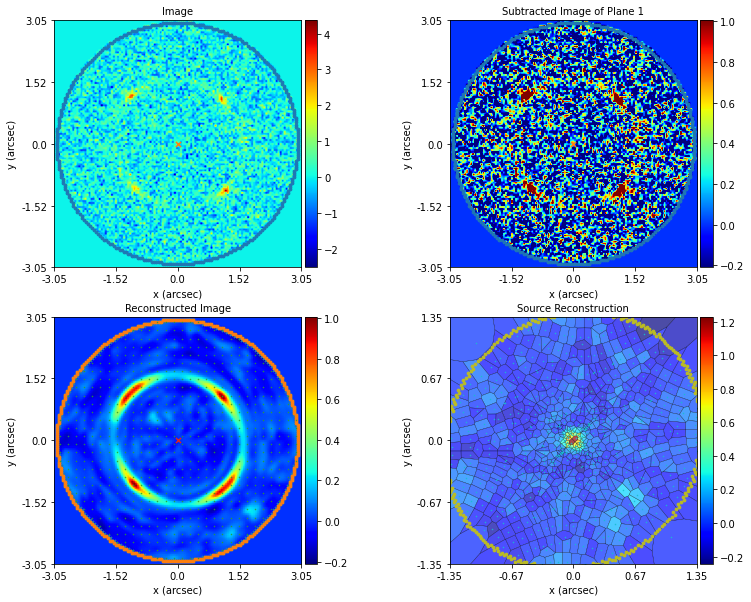

-10102.312472246065


In [9]:
fit_super_compact = fit_imaging_with_voronoi_magnification_pixelization(
    imaging=imaging_source_super_compact, mask=mask, regularization_coefficient=3.1
)

fit_imaging_plotter = aplt.FitImagingPlotter(
    fit=fit_super_compact, include_2d=include_2d
)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

print(fit_super_compact.log_evidence)

Okay, so what did we learn? The more compact our source, the worse the fit. This happens even though we are using the 
*correct* lens mass model, telling us that something is going fundamentally wrong with our source reconstruction and 
`Inversion`. As you might of guessed, both our `Pixelization` and `Regularization` scheme are to blame!

__Pixelization__

For the `Pixelization` the problem is the same one we found when comparing the `Rectangular` and _VoronoiMagnification_
_Pixelization_`s. Put simply, we are not dedicating enough source-pixels to the central regions of the source 
reconstruction, e.g. where it`s brightest. As the source becomes more compact, the source reconstruction doesn`t 
have enough resolution to resolve its fine-detailed central structure, causing the fit to the image to degrade.

Think about it, as we made our sources more compact we go from reconstructing them using ~100 source pixels, to ~20 
source pixels to ~ 10 source pixels. This is why we advocated not using the `Rectangular` `Pixelization`.n the previous 
chapter!

It turns out that adapting to the magnification wasn`t the best idea all along. As we simulated more compact sources 
the magnification (which is determined via the mass model) didn`t change. So, we foolishly reconstructed each source
using fewer and fewer pixels, leading to a worse and worse fit! Furthermore, these source's happened to be located in 
the highest magnification regions of the source plane! If the source's were further away from the centre of the 
caustic, the `VoronoiMagnification` `Pixelization`.would use *even less* pixels to reconstruct it. That is NOT what we 
want!

__Regularization__

Regularization also causes problems. When using a `Constant` `Regularization` scheme, we regularize the source by 
adding up the difference in fluxes between all source-pixels multiplied by one single value of a `Regularization`
coefficient. This means that, every single source pixel receives the same `level` of `Regularization`, regardless of 
whether it is reconstructing the bright central regions of the source or its faint exterior regions. Lets look:

NOTE: Here we are going to use a trick to plot the `regularization_weights`. The `FitImagingPlotter` does not have a
method that is able to plot this attribute of the `Inversion`. However, the `FitImagingPlotter` has its own 
`InversionPlotter` which we can use to make this plot. The benefit of using this is that it inherits from the
`FitImagingPlotter` properties like the caustics, so they appear on the figure (this would not happen if we
manually set up an `InversionPlotter` as we did in previous tutorials.

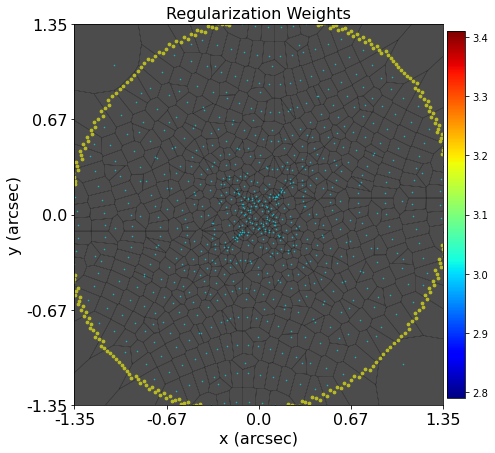

In [10]:
inversion_plotter = fit_imaging_plotter.inversion_plotter_of_plane(plane_index=1)
inversion_plotter.figures(regularization_weights=True)

As you can see, all pixels are regularized with our input regularization_coefficient value of 3.6.

Is this the best way to regularize the source? Well, as you`ve probably guessed, it isn't. But why not? Its 
because different regions of the source demand different levels of regularization:

 1) In the source's central regions its flux gradient is steepest; the change in flux between two source pixels is 
 much larger than in the exterior regions where the gradient is flatter (or there is no source flux at all). To 
 reconstruct the detailed structure of the source's cuspy inner regions, the regularization_coefficient needs to 
 be much lower to avoid over-smoothing.

 2) On the flip side, the source reconstruction wants to assume a high regularization_coefficient further out 
 because the source's flux gradient is flat (or there is no source signal at all). Higher 
 regularization_coefficients will increase the Bayesian log evidence because by smoothing more source-pixels it 
 makes the solution `simpler`, given that correlating the flux in these source pixels the solution effectively 
 uses fewer source-pixels (e.g. degrees of freedom).

So, herein lies the pitfall of a constant `Regularization` scheme. Some parts of the reconstructed source demand a 
low regularization_coefficient whereas other parts want a high value. Unfortunately, we end up with an intermediate 
regularization coefficient that over-smooths the source's central regions whilst failing to fully correlate exterior 
pixels. Thus, by using an adaptive `Regularization` scheme, new solutions that further increase the Bayesian log 
evidence become accessible.

__Noise Map__

Before we wrap up this tutorial, I want us to also consider the role of our noise-map and get you thinking about 
why we might want to scale its variances. Lets look at the super-compact fit again;

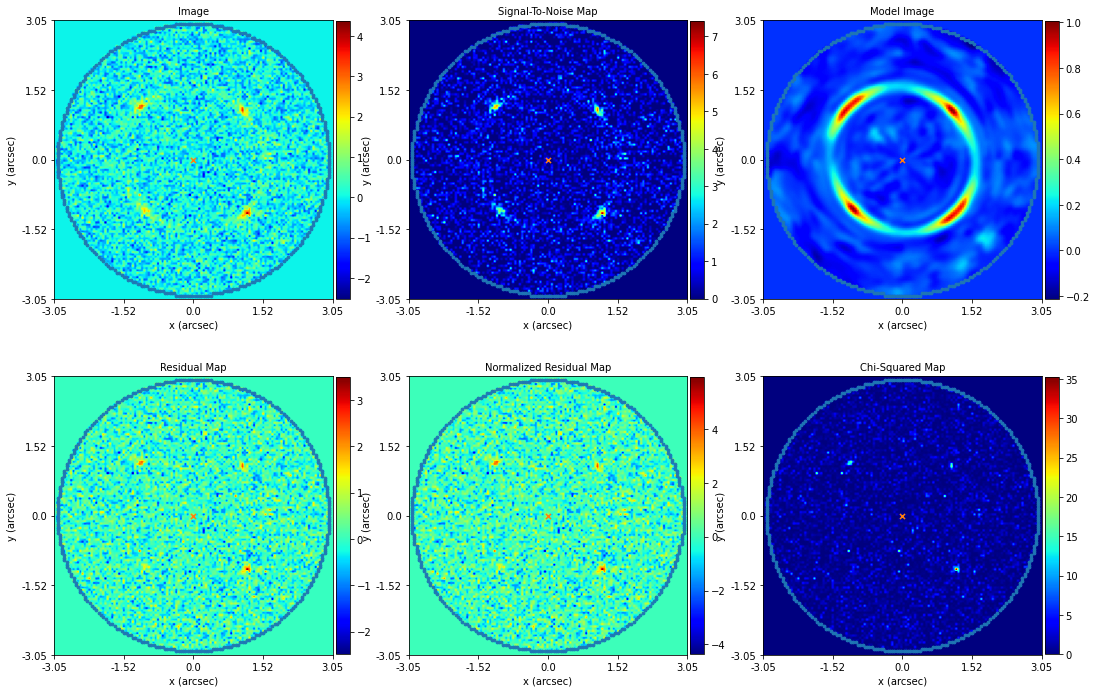

In [11]:
fit_imaging_plotter.subplot_fit_imaging()

So, whats the problem? Look closely at the `chi-squared image`. Here, you'll note that a small subset of our data 
have extremely large chi-squared values. This means our `NonLinearSearch` (which is trying minimize chi-squared) is 
going to seek solutions which primarily only reduce these chi-squared values. For the image above a small subset of 
the data (e.g. < 5% of pixels) contributes to the majority of the log likelihood (e.g. > 95% of the overall chi-squared). 
This is *not* what we want, as instead of using the entire surface brightness profile of the lensed source galaxy to 
fit our lens model, we end up using only a small subset of its brightest pixels.

In the context of the Bayesian log evidence things become even more problematic. The Bayesian log evidence is trying to 
achieve a well-defined solution; a solution that provides a reduced chi-squared of 1. This solution is poorly defined 
when the chi-squared image looks like the one above. When a subset of pixels have chi-squareds > 300, the only way 
to achieve a reduced chi-squared 1 is to reduce the chi-squareds of other pixels to 0, e.g. by over-fitting their 
noise. Thus, we quickly end up in a regime where the choice of regularization_coefficient is ill defined.

With that, we have motivated hyper_galaxy-mode. To put it simply, if we don't adapt our pixelization, regularization
and noise-map, we will get solutions which reconstruct the source poorly, regularize the source sub-optimally and 
over-fit a small sub-set of image pixels. Clearly, we want adaptive `Pixelization`, `Regularization` and 
noise-maps, which what we'll cover tutorials 2, 3 and 4!